<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/2B.%20Dealing%20with%20missing%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Housekeeping**

### **1.1 Load libraries**

In [71]:
#basic libraries
import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.preprocessing import LabelEncoder
# from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [72]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

### **1.2 Load data**

In [73]:
train_labels = pd.read_csv('../data/train/labels.csv')
train_values = pd.read_csv('../data/train/features.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('../data/test/test.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])
cleaned_df = pd.read_csv('cleaned_df.csv')



/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5747/64510905.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_df = pd.read_csv('cleaned_df.csv')


In [74]:
#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')

#concatenate train and test for data visualization
raw = pd.concat([train, test_values])
raw.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### **1.3 Custom functions**

In [75]:
#function to create density plot
def impute_checker (feature, imputed_dataset, title):
  train[feature].plot(kind='kde', c='black')
  imputed_dataset[feature].plot(kind='kde', style = "--", c= '#66c2a5')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.title(title)
  plt.show()


In [76]:
def feature_importances (model):
  model.fit(X, y)
  features= X.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(10,10)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance')
plt.show()

# **2 Missing data**

In [77]:
#The percentage of missing data varies from 0.6% to 98.7%
missing = round((raw.isna().sum())/len(raw)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

num_private          98.7
amount_tsh           70.1
scheme_name          47.5
population           36.1
construction_year    35.0
gps_height           34.5
status_group         20.0
installer             7.4
funder                7.4
scheme_management     6.5
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
dtype: float64

<Axes: >

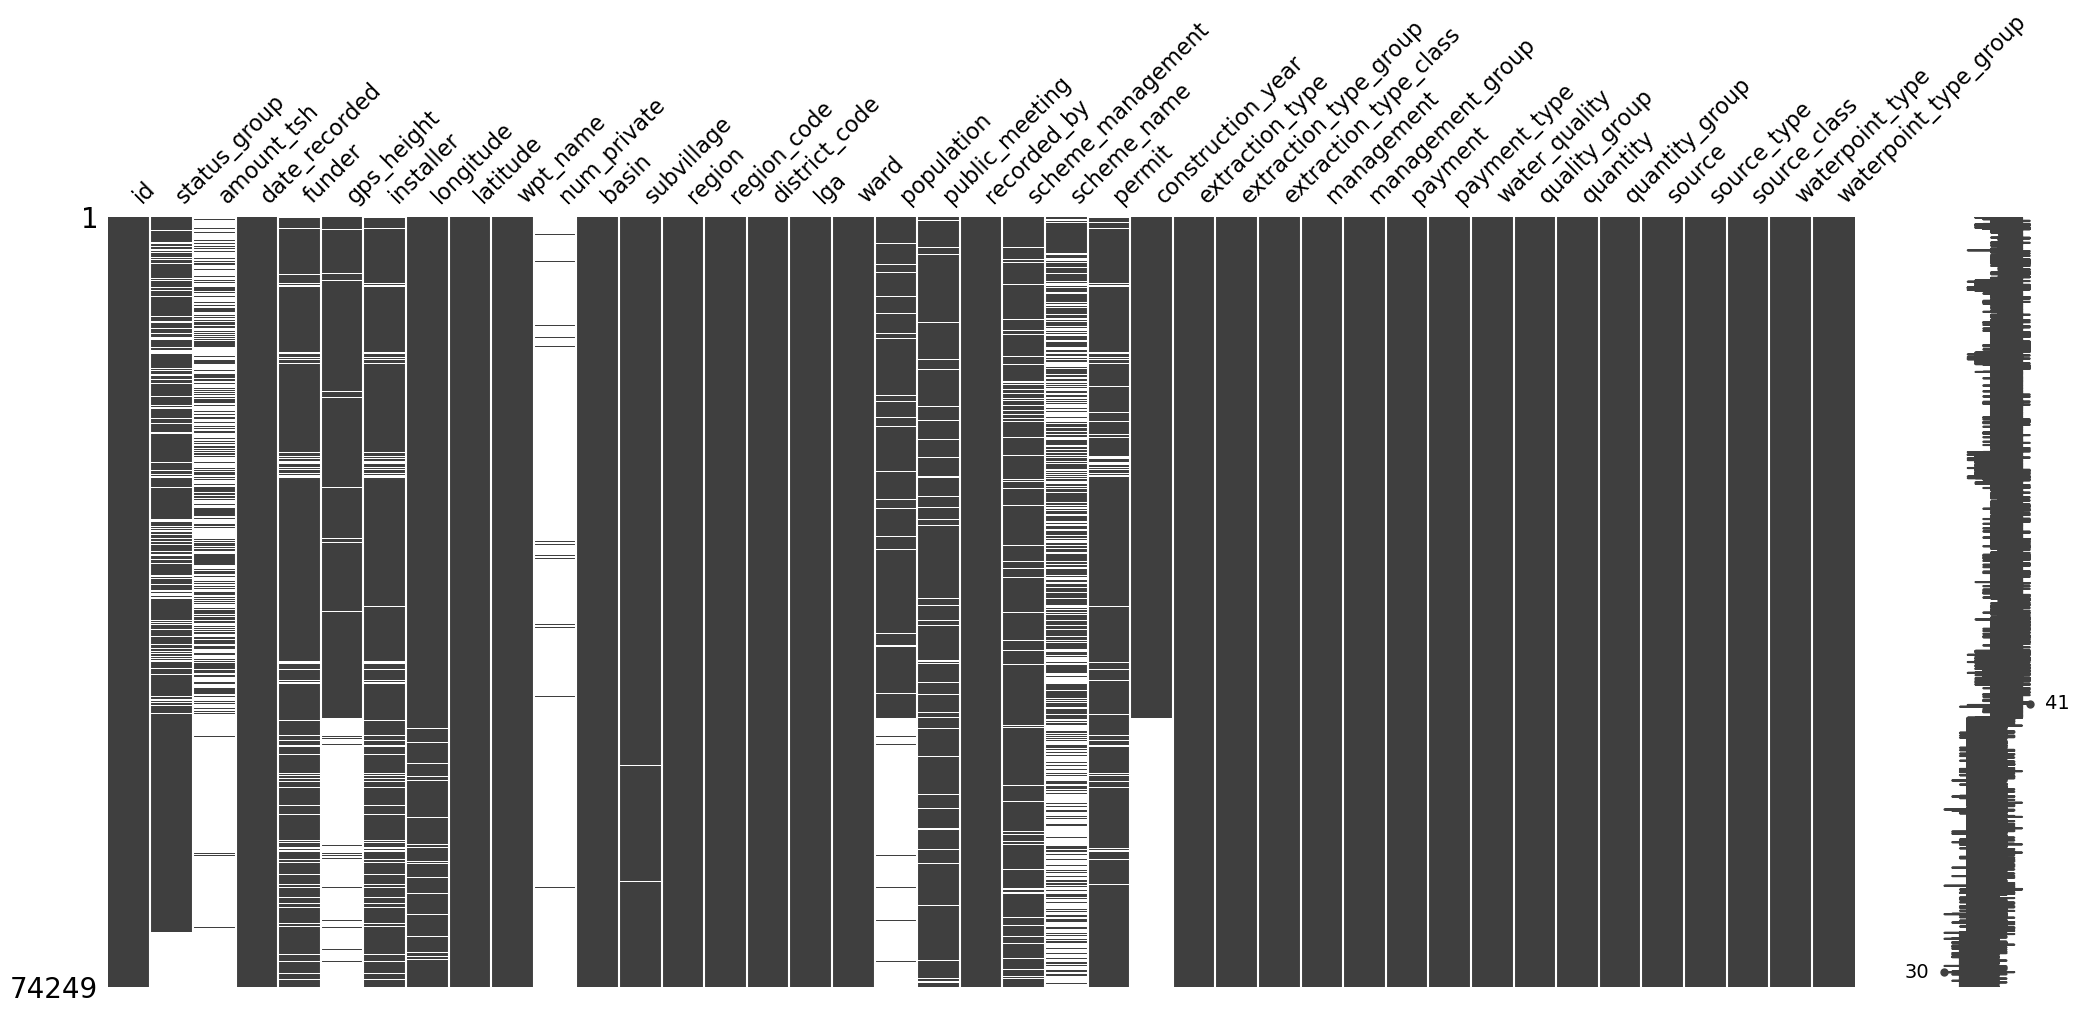

In [78]:
#there is a clear relation between missing values in gps_heigt, population, construction year and to some degree longitude: data is not missing at random
sorted =raw.sort_values('construction_year')
msno.matrix(sorted)

<Axes: >

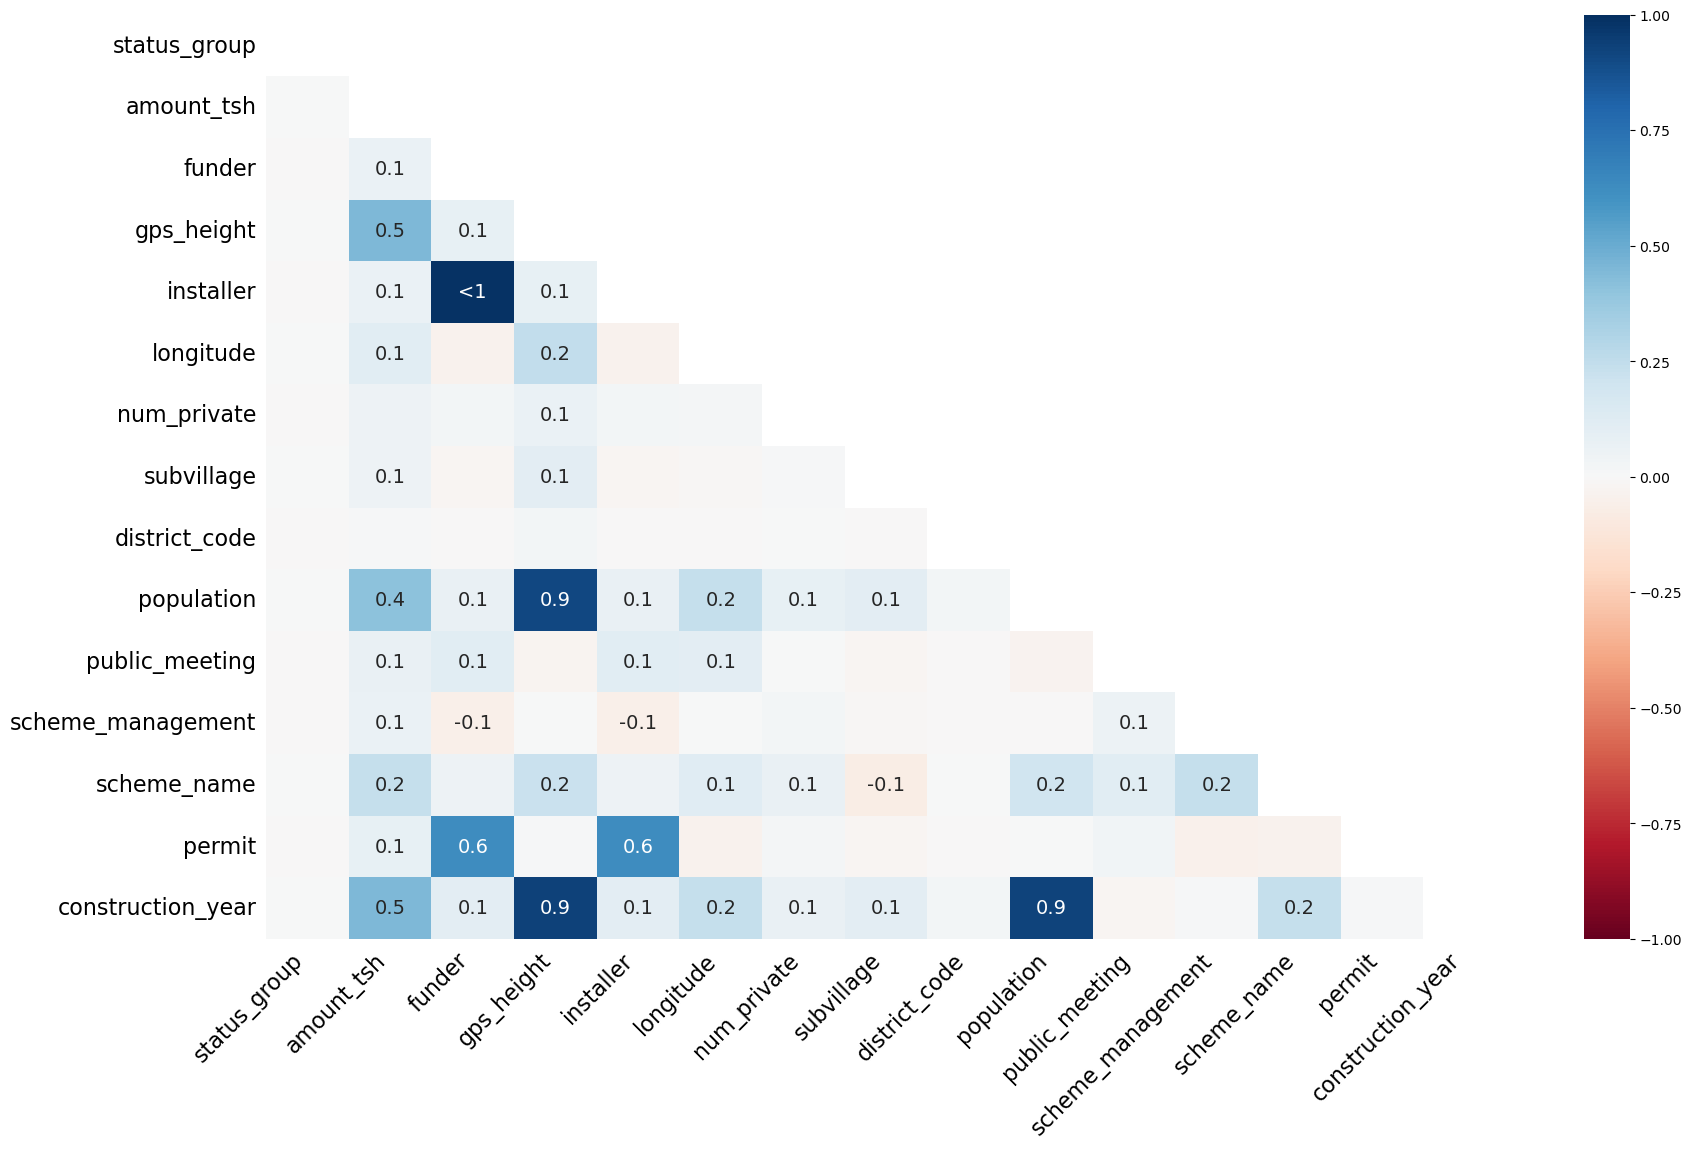

In [79]:
#strong correlation in missingness
msno.heatmap(raw)

Data is clearly not missing at random. This is relevant, because it influences what imputation strategy to choose.
* Mean imputation is not a good solution here as this method of imputation should only be used when data is missing completely at random.
* When a lot of data is missing, imputing by the mean would distort the distribution of the feature and reduce variance.

 Click [here](https://medium.com/analytics-vidhya/feature-engineering-part-1-mean-median-imputation-761043b95379) to read more on this topic.






**Let's compare 3 different imputation techniques:**
1. Mean imputing (assumption: data is missing completely at random - MCAR)
2. Mice imputing (assumption: data is missing at random - MAR)
3. Manual imputation

### **2.1 Mean/Mode imputation**

In [80]:
#create a copy of the training and testing data that will be imputed using means and modes
mean_mode_train = train.copy()
mean_mode_test = test_values.copy()

In [81]:
#create a list of numerical and categorical columns that contain missing data
numerical = ['num_private', 'amount_tsh', 'population', 'construction_year', 'gps_height', 'longitude']
categorical = ['scheme_name', 'installer', 'funder', 'scheme_management', 'public_meeting', 'permit', 'public_meeting', 'subvillage']

#impute numerical columns by the mean
for col in numerical:
  mean_mode_train[col] = mean_mode_train[col].fillna(mean_mode_train[col].mean())
  mean_mode_test[col] = mean_mode_test[col].fillna(mean_mode_train[col].mean())  #impute test set with the mean of the training data

#and categorical columns by the mode
for col in categorical:
  mean_mode_train[col] = mean_mode_train[col].fillna(mean_mode_train[col].mode()[0])
  mean_mode_test[col] = mean_mode_test[col].fillna(mean_mode_train[col].mode()[0]) #impute test set with the mode of the training data

**Let's see how mean imputing impacts the distribution of numerical features**

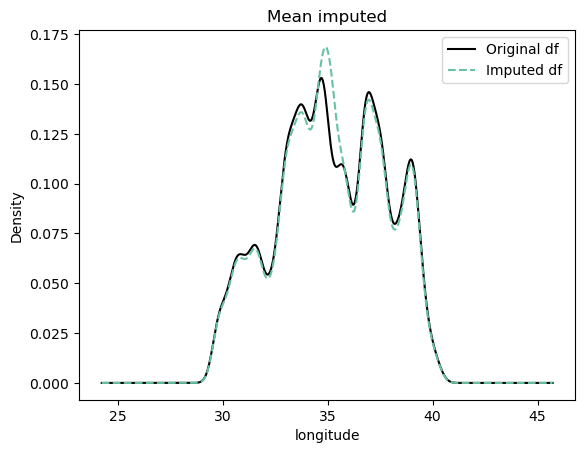

In [82]:
#mean imputing has no major impact on the distribution of the longitude. This feature has 3.1% missing data. 
impute_checker('longitude', mean_mode_train, 'Mean imputed')

In [83]:
#after mean imputation the variance is only slightly lower
mean_mode_train['longitude'].var(), train['longitude'].var()

(6.591325039456337, 6.798727549988317)

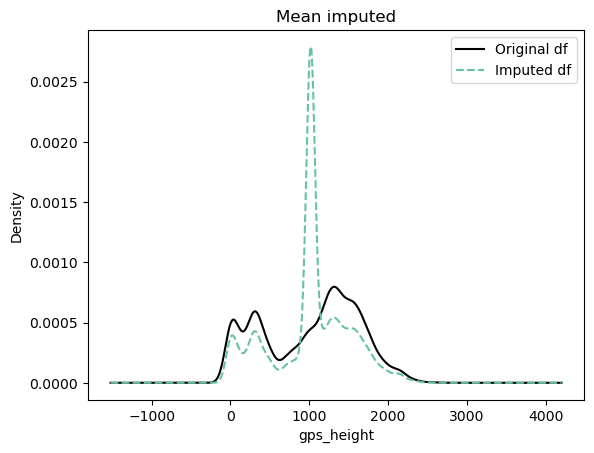

In [84]:
#mean imputing severely changes the distribution of gps height
impute_checker('gps_height', mean_mode_train, 'Mean imputed')

In [85]:
#mean imputing reduces the variance in this feature
mean_mode_train['gps_height'].var(), train['gps_height'].var()

(246129.78877180838, 375237.21653622104)

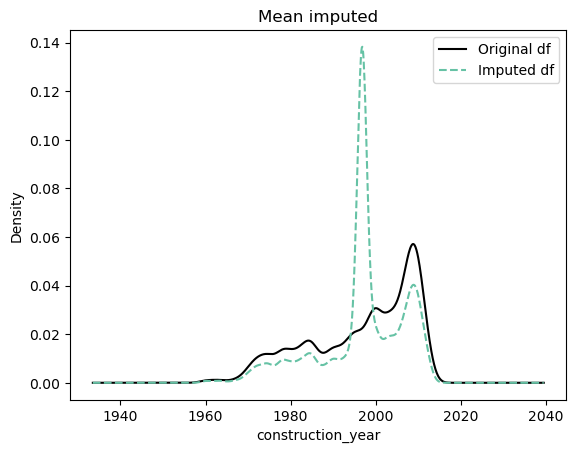

In [86]:
#mean imuting results in a massive peak around 1995 that was originally not present in the data
impute_checker('construction_year', mean_mode_train, 'Mean imputed')

In [87]:
#mean imputing reduces the variance in this feature
mean_mode_train['construction_year'].var(), train['construction_year'].var()

(101.32164880384028, 155.55190735719395)

### **2.2 Mice**

In [88]:
#create a copy of the original dataset that will be mice imputed
mice_train = train.copy()
mice_test = test_values.copy()

In [89]:
#mice imputing requires numerical columns. For now we will leave out some high cardinality features
mice_train = mice_train.drop([   'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'date_recorded', 'district_code', 'num_private', 'amount_tsh'],axis=1) #drop high cardinality features
mice_test = mice_test.drop([   'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'date_recorded', 'district_code', 'num_private', 'amount_tsh'],axis=1) 


In [90]:
#define the X-variables for the mice imputing
mice_train_features = mice_train.drop('status_group', axis=1)

#create a list of all categorical features
categorical_cols = [cname for cname in mice_train_features.columns if
                    mice_train_features[cname].dtype == "object"]

In [91]:
# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  mice_train_features[col] = le.fit_transform(mice_train_features[col])
  mice_test[col] = le.transform(mice_test[col])


In [92]:
# #create mice imputer
# mice_imputer = IterativeImputer()

# #fit and transform on train and transform test
# mice_train_features.iloc[:, :] = (mice_imputer.fit_transform(mice_train_features))
# mice_test.iloc[:, :] = mice_imputer.transform(mice_test)

from sklearn.impute import SimpleImputer

# create imputer object with desired strategy
imputer = SimpleImputer(strategy='mean')

# fit and transform on train and transform test
mice_train_features.iloc[:, :] = imputer.fit_transform(mice_train_features)
mice_test.iloc[:, :] = imputer.transform(mice_test)

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5747/2097845863.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mice_train_features.iloc[:, :] = imputer.fit_transform(mice_train_features)
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5747/2097845863.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mice_test.iloc[:, :] = imputer.transform(mice_test)


**Let's see how mice imputing impacts the distribution of numerical features**

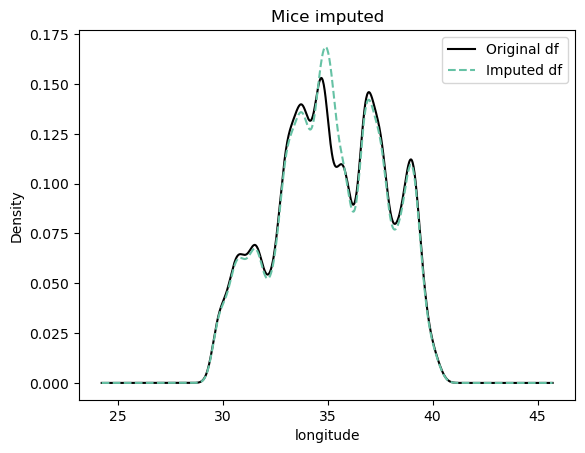

In [93]:
#mice imputer appears to work better than than mean imputing
impute_checker('longitude', mice_train_features, 'Mice imputed')

In [94]:
#mice imputing barely has an impact on variance
mice_train_features['longitude'].var(), train['longitude'].var()

(6.591325039456337, 6.798727549988317)

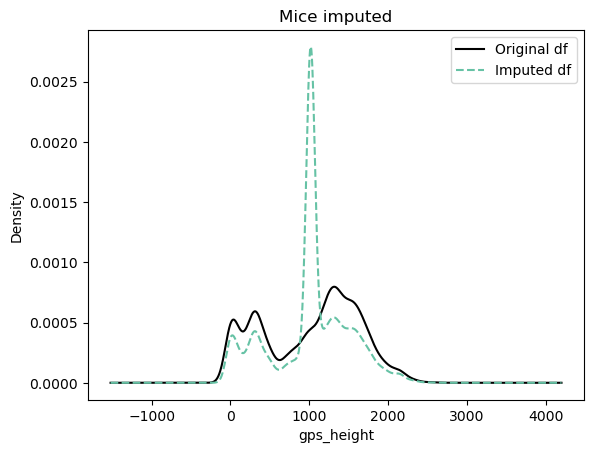

In [95]:
#mice imputing works a lot better for gps height than mean imputing
impute_checker('gps_height', mice_train_features, 'Mice imputed')

In [96]:
#mice imputing does reduce variance, but not as much as mean imputing
mice_train_features['gps_height'].var(), train['gps_height'].var()

(246129.78877180838, 375237.21653622104)

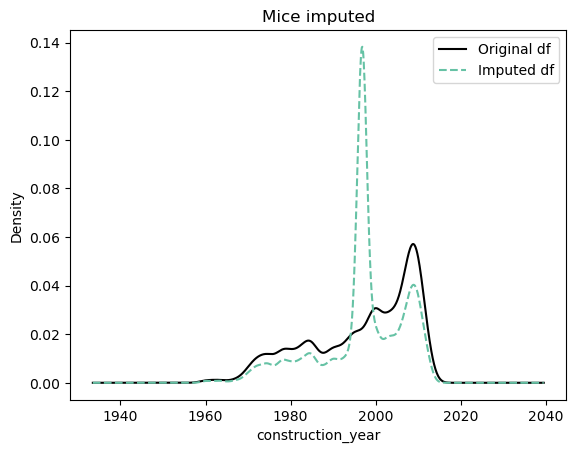

In [97]:
#mean imuting results in a massive peak around 1995 that was originally not present in the data
impute_checker('construction_year', mice_train_features, 'Mice imputed')

In [98]:
#mice imputing doesn't seem to work so well for the construction year
mice_train_features['construction_year'].var(), train['construction_year'].var()

(101.32164880384028, 155.55190735719395)

### **2.3 Manual imputing**

Let's see how well I did with my manually imputed dataframe (code available in Github repository)

In [99]:
#define train and test 
train_manual = cleaned_df[cleaned_df ["id"].isin(train_values["id"])]
test_manual =  cleaned_df[cleaned_df ["id"].isin(test_values["id"])]

In [100]:
#define the features that need to be encoded
train_manual  = train_manual.drop(['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'date_recorded', 'district_code'],axis=1) #drop high cardinality features
test_manual = test_manual.drop(['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'date_recorded', 'district_code'],axis=1) 

In [101]:
#define the X-variables
X = train_manual.drop(['id', 'status_group'], axis=1)
y = train_manual['status_group']

In [102]:
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

In [103]:
# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  train_manual[col] = le.fit_transform(train_manual[col])
  test_manual[col] = le.transform(test_manual[col])

**Let's see how mice imputing impacts the distribution of numerical features**

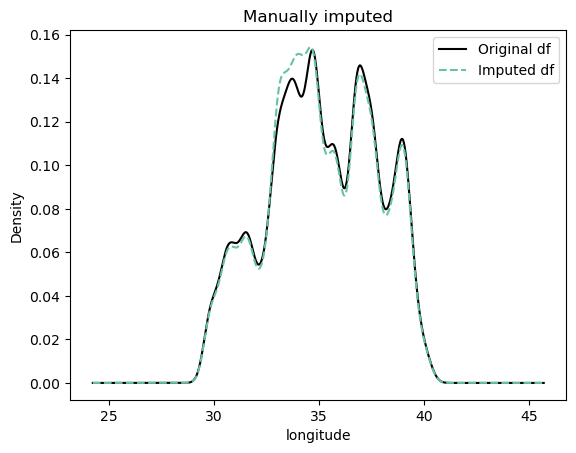

In [104]:
#my manually imputed longitude looks pretty good
impute_checker('longitude', train_manual, 'Manually imputed')

In [105]:
#variance of the manually imputed feature is as good as the mice imputed df
train_manual ['longitude'].var(), train['longitude'].var()

(6.658198536063177, 6.798727549988317)

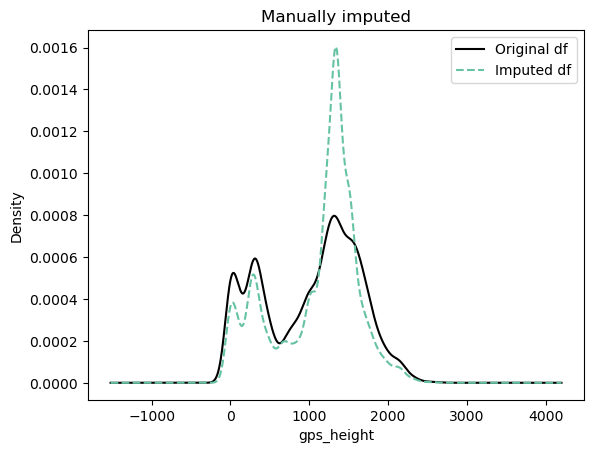

In [106]:
# Hmm. that doesn't look good
impute_checker('gps_height', train_manual, 'Manually imputed')

In [107]:
#my manually imputed gps height is better than the mean encoded dataframe, but a lot lower than the mice imputed dataframe
train_manual ['gps_height'].var(), train['gps_height'].var()

(287643.4649465634, 375237.21653622104)

In [108]:
train_manual.columns

Index(['Unnamed: 0', 'id', 'status_group', 'amount_tsh', 'latitude',
       'num_private', 'basin', 'region', 'region_code', 'public_meeting',
       'recorded_by', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'longitude', 'permit',
       'scheme_management', 'construction_year', 'gps_height', 'population'],
      dtype='object')

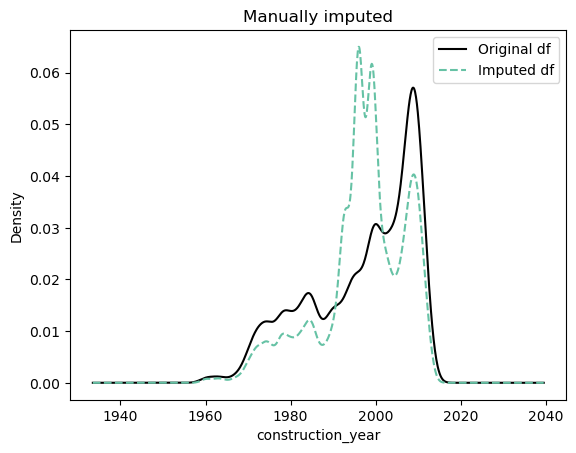

In [109]:
#Again we see an odd spike in the 90s
impute_checker('construction_year', train_manual, 'Manually imputed')

In [110]:
#variance is lowered by the manual imputation, but only slightly more than in the mice imputed dataframe
train_manual ['construction_year'].var(), train['construction_year'].var()

(104.18008815237289, 155.55190735719395)

# **3 Model performance**

### **3.1 Mean/Mode encoding**

In [111]:
#we will first need to encode the mean_mode encoded dataframe

#define the X-varaiables
mean_mode_features= mean_mode_train.drop([  'status_group', 'id', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'date_recorded', 'district_code' , 'num_private', 'amount_tsh'],axis=1) 

#create a list of all categorical features
categorical_cols = [cname for cname in mean_mode_features.columns if
                    (mean_mode_features[cname].dtype == "object" )| (mean_mode_features[cname].dtype == "bool" ) ]

# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  mean_mode_features[col] = le.fit_transform(mean_mode_features[col])

Accuracy: 0.804 (0.005)


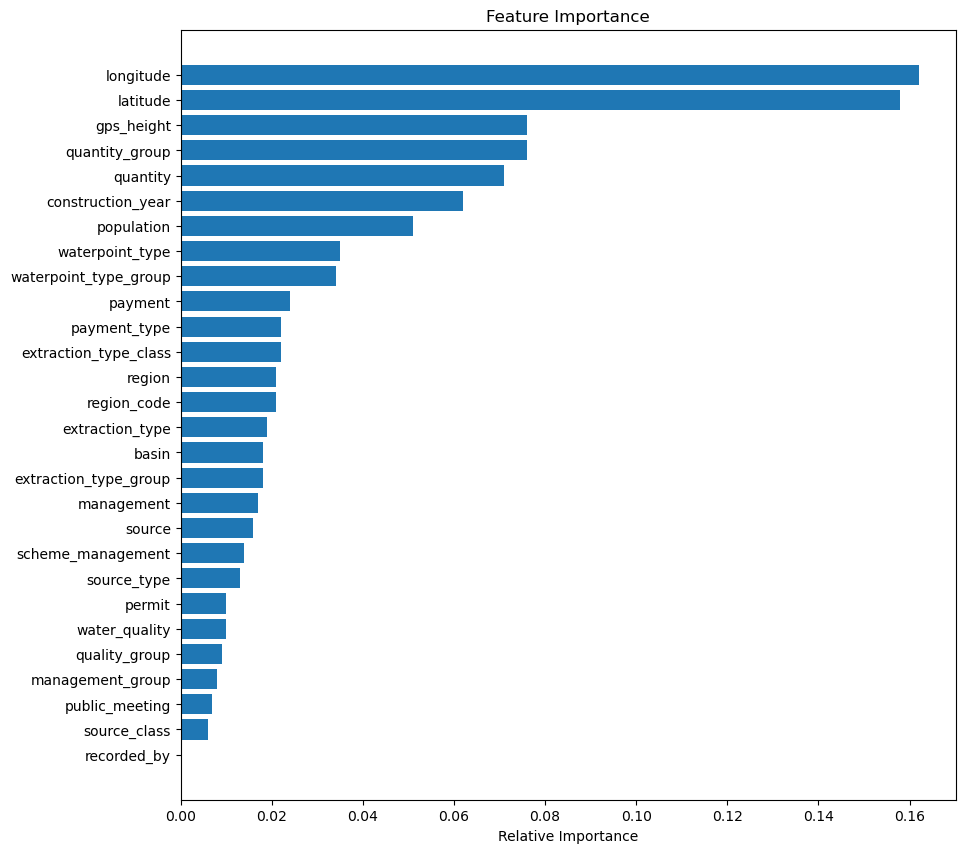

In [112]:
#define X and y varaibles
X = mean_mode_features
y = mean_mode_train['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf)


### **3.2 Mice**

Accuracy: 0.804 (0.006)


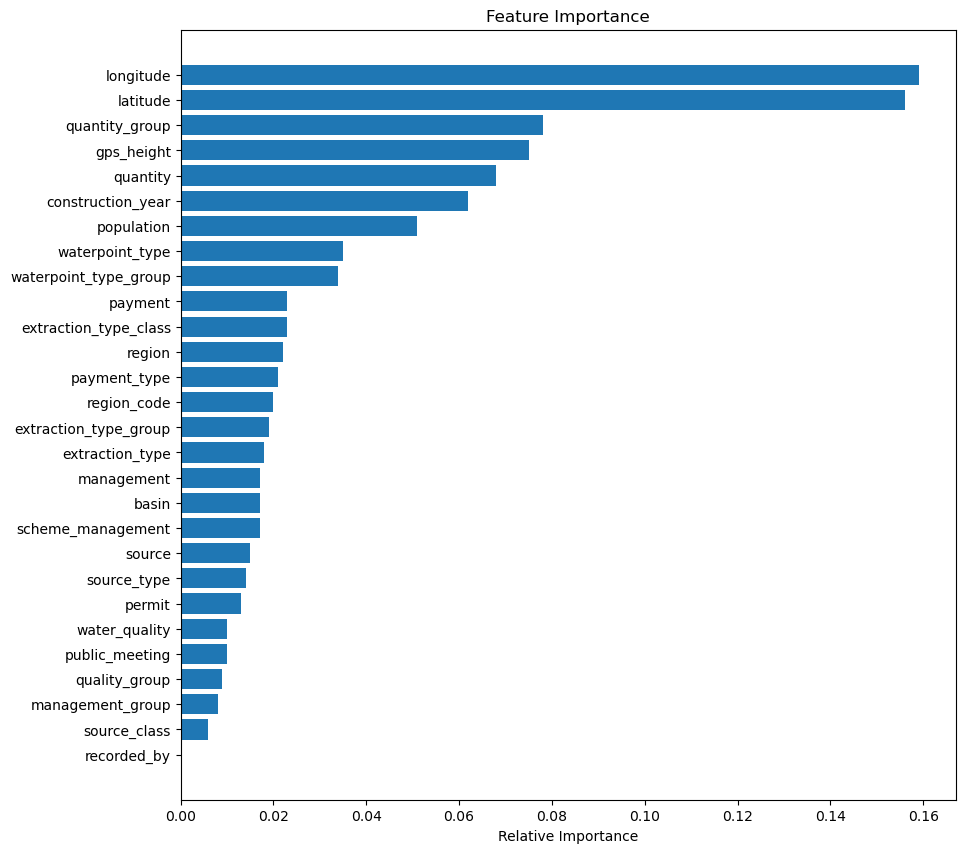

In [113]:
#define X and y varaibles
X = mice_train_features.drop('id', axis=1)
y = mice_train['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf)


### **3.3 Manual imputing**

Accuracy: 0.803 (0.004)


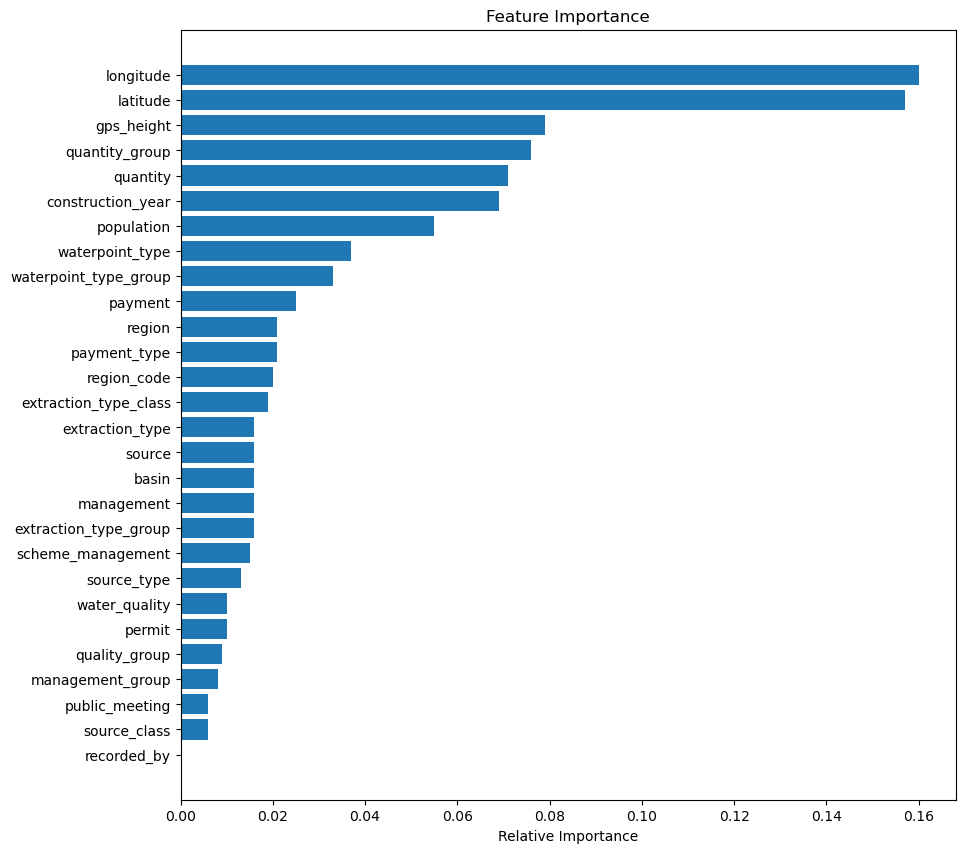

In [114]:
#define X and y varaibles
X = train_manual.drop(['id', 'status_group', 'Unnamed: 0', 'num_private', 'amount_tsh'], axis=1) 
y = train_manual['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf)


# **4 Conclusion**

I have performed three imputation strategies and assessed their performance using a random forest classifier. Despite the fact that the three imputation strategies had very different effects on the distribution of certain variables, their resulting model performance is very comparable. Enough variance was left for the model to learn patterns in the data. 